**AI Agent using Langgraph, Langchain and Amazon Nova Premier**

Use case : AI Candidate Screening.

This agent help you analyze CV against job requirements, give result for the next step of the recruitment process and create interview question.

In [ ]:
# Install langgraph, AWS and langchain
!pip install python-dotenv packaging langchain langchain-aws langgraph pypdf

In [ ]:
import os
# Load environment and save AWS token
from dotenv import load_dotenv
load_dotenv("awskey.txt")
# Get AWS access key, AWS secret key and AWS region
accesskey = os.getenv("AWS_ACCESS_KEY")
secretkey = os.getenv("AWS_SECRET_KEY")
region = os.getenv("AWS_REGION")

**Structure of this AI Agent**

**User --> Extract CV --> Compare and Match between Requirements and CV --> Result to the next step of the recruitment process --> Create Interview Question --> End**

In [ ]:
# Import Langgraph
from langchain_aws import ChatBedrock
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command

In [ ]:
# Use Amazon Nova Premier
model = ChatBedrock(
    model = "us.amazon.nova-premier-v1:0",
    region = region, aws_access_key_id = accesskey, aws_secret_access_key = secretkey
)

In [ ]:
# Extract CV PDF file
from pypdf import PdfReader
reader = PdfReader("Always Winner CV.pdf")
page = reader.pages[0]
text = page.extract_text()
print(text)

Name  :  Always  Winner  
Phone  Number  :  000888999  
Email  Address  :  alwayswinner@gmail.com 
Work  Experience  :   
AI  Engineer,  Winner,  LLC  |  New  York  City,  NY  |  January  1,  2025  –  Present  
Junior  AI  Engineer,  Nerwin,  LLC  |  New  York  City,  NY  |  January  1,  2024  –  December  31,  2024  
Education  :   
Bachelor  of  Artificial  Intelligence  |  University  of  AI  Everywhere  |  New  York  City,  NY  |  2023  
Technical  Skills  :   
●  Programming  Languages:  Python  (TensorFlow,  PyTorch,  Keras,  scikit-learn,  Hugging  
Face
 
Transformers),
 
Java,
 
C++
 ●  Generative  AI:  GANs  (StyleGAN,  BigGAN),  VAEs,  Diffusion  Models,  Autoregressive  
Models,
 
LLMs
 
(GPT,
 
BERT,
 
LLaMA),
 
Stable
 
Diffusion
 ●  Agentic  AI  ●  Machine  Learning:  Supervised  Learning,  Unsupervised  Learning,  Transfer  Learning,  
Model
 
Optimization,
 
Hyperparameter
 
Tuning
 ●  Cloud  Platforms:  AWS  (Sagemaker,  EC2,  S3),  Azure  (Azure  ML),  Google  Cloud 

**Create Compare and Match between Requirements and CV agent and Create first node**

In [ ]:
compareMatch = create_react_agent(
    model,
    tools=[],
    prompt="""
    You are a virtual human resources expert. You help me compare and match between curriculum vitae and requirements like this :
    1. Work across the AI lifecycle: from data preparation and model development to evaluation and deployment.
    2. Fine-tune and integrate LLMs (like OpenAI and Claude) into ERP workflows.
    3. Build smart features such as recommendation engines, forecasting modules, NLP tools, and more.
    Preferred requirements :
    Develop and maintain scalable cloud-based AI solutions across multi-cloud platforms (AWS, GCP, Azure).
    Then write output structure like this:
    MINIMAL REQUIREMENTS ANALYSIS :

    Requirement 1:

    Requirement n (n is the number of requirement):

    PREFERRED REQUIREMENTS ANALYSIS :

    OVERALL MATCH PERCENTAGE :

    Strengths:

    Potential Gaps:
    """
)

def compareMatchNode(state: MessagesState):
    result = compareMatch.invoke(state)
    return Command(update={"messages": result["messages"]}, goto="resultNextStep")

**Create Result to the next step of the recruitment process agent and Create second node**

In [ ]:
resultNextStep = create_react_agent(
    model,
    tools=[],
    prompt="""
    You are a virtual human resources expert. You help me add value from 0 until 10 to the next step of recruitment process.
    Write output structure MUST like example this :
    RESULT : ..... of 10
    """
)

def resultNextStepNode(state: MessagesState):
    result = resultNextStep.invoke(state)
    return Command(update={"messages": result["messages"]}, goto="createInterviewQuestion")

**Create Interview Questions agent and Create third node**

In [ ]:
createInterviewQuestion = create_react_agent(
    model,
    tools=[],
    prompt="""
    You are a virtual human resources expert. You help me create 3 interview questions about CV PDF file that already extracted.
    BUT if result are is LESS THAN 7 of 10, don't create interview questions.
    Otherwise, create 3 interview questions about CV PDF file that already extracted.
    Write output structure MUST like example this :
    QUESTION 1 : .....
    QUESTION 2 : .....
    QUESTION 3 : .....
    """
)

def createInterviewQuestionNode(state: MessagesState):
    result = createInterviewQuestion.invoke(state)
    return Command(update={"messages": result["messages"]}, goto=END)

**Create AI Agent Graph then Connect between Graphs and Nodes**

In [ ]:
# Create StateGraph
workflow = StateGraph(MessagesState)
# Connect between first graph and node
workflow.add_node("compareMatch", compareMatchNode)
# Connect between second graph and node
workflow.add_node("resultNextStep", resultNextStepNode)
# Connect between third graph and node
workflow.add_node("createInterviewQuestion", createInterviewQuestionNode)

# Start from first graph and node
workflow.add_edge(START, "compareMatch")
# Go to second graph and node
workflow.add_edge("compareMatch", "resultNextStep")
# Go to third graph and node
workflow.add_edge("resultNextStep", "createInterviewQuestion")
# Finish end
workflow.add_edge("createInterviewQuestion", END)
graph = workflow.compile()

**Run AI Agent Graph then see Result**

In [ ]:
# Always Winner CV PDF file
events = graph.invoke(
    {
        "messages": [
            ("user", f"{text}")
        ],
    },
)
messages = events["messages"]
print(messages)

[HumanMessage(content='Name  :  Always  Winner  \nPhone  Number  :  000888999  \nEmail  Address  :  alwayswinner@gmail.com \nWork  Experience  :   \nAI  Engineer,  Winner,  LLC  |  New  York  City,  NY  |  January  1,  2025  –  Present  \nJunior  AI  Engineer,  Nerwin,  LLC  |  New  York  City,  NY  |  January  1,  2024  –  December  31,  2024  \nEducation  :   \nBachelor  of  Artificial  Intelligence  |  University  of  AI  Everywhere  |  New  York  City,  NY  |  2023  \nTechnical  Skills  :   \n●  Programming  Languages:  Python  (TensorFlow,  PyTorch,  Keras,  scikit-learn,  Hugging  \nFace\n \nTransformers),\n \nJava,\n \nC++\n ●  Generative  AI:  GANs  (StyleGAN,  BigGAN),  VAEs,  Diffusion  Models,  Autoregressive  \nModels,\n \nLLMs\n \n(GPT,\n \nBERT,\n \nLLaMA),\n \nStable\n \nDiffusion\n ●  Agentic  AI  ●  Machine  Learning:  Supervised  Learning,  Unsupervised  Learning,  Transfer  Learning,  \nModel\n \nOptimization,\n \nHyperparameter\n \nTuning\n ●  Cloud  Platforms:  AWS

In [ ]:
print("Compare and Match between Requirements and CV :")
print(messages[1].content)

Compare and Match between Requirements and CV :
MINIMAL REQUIREMENTS ANALYSIS :

Requirement 1:
- The candidate has experience working as an AI Engineer and Junior AI Engineer, which implies involvement in the AI lifecycle.

Requirement 2:
- The candidate has listed LLMs (like GPT, BERT, LLaMA) under their technical skills, indicating experience with fine-tuning and integrating these models.

Requirement 3:
- The candidate has experience with generative AI, machine learning, and NLP tools, which are essential for building smart features like recommendation engines and forecasting modules.

PREFERRED REQUIREMENTS ANALYSIS :
- The candidate has experience with AWS (Sagemaker, EC2, S3), Azure (Azure ML), and Google Cloud Platform (Vertex AI), demonstrating the ability to develop and maintain scalable cloud-based AI solutions across multi-cloud platforms.

OVERALL MATCH PERCENTAGE : 
- 90%

Strengths:
- Extensive experience with LLMs and generative AI.
- Proficiency in multi-cloud platform

In [ ]:
print("Result to the next step of the recruitment process :")
print(messages[2].content)

Result to the next step of the recruitment process :


RESULT : 9 of 10

The candidate is highly qualified and meets most of the key requirements, with only minor gaps that could potentially be addressed through on-the-job learning or additional clarification during the interview process.


In [ ]:
print("Interview Questions :")
print(messages[3].content)

Interview Questions :


QUESTION 1 : Can you describe a specific project where you fine-tuned and integrated a large language model (LLM) like GPT or BERT into a production environment? What challenges did you face and how did you overcome them?

QUESTION 2 : How have you utilized your experience with multi-cloud platforms (AWS, Azure, GCP) to develop and maintain scalable AI solutions? Can you provide an example of a project that required cross-platform integration?

QUESTION 3 : Given your background in generative AI and machine learning, how would you approach building a recommendation engine for a new e-commerce platform? What tools and methodologies would you use to ensure its effectiveness and scalability?


**Try upload second CV PDF file**

In [ ]:
# Extract CV PDF file
from pypdf import PdfReader
reader = PdfReader("Sonny Wawwak CV.pdf")
page = reader.pages[0]
texted = page.extract_text()
print(texted)

Sonny  Wawwak  
UI/UX
 
Designer
 
Address
 
:
 
Konoha
 
Phone
 
:
 
+62
 
812-3456-7890
 
Email
 
Address
 
:
 
sonny.wawwak@email.com
 
Skills  ●  UI  Design  (Web  &  Mobile)  ●  UX  Research  &  Analysis  ●  Wireframing  &  Prototyping  ●  Design  Systems  &  Style  Guides  ●  User  Flows  &  Journey  Mapping  ●  Usability  Testing  ●  Tools:  Figma,  Adobe  XD,  Sketch,  InVision,  Photoshop,  Illustrator  ●  HTML,  CSS  (basic  understanding)  ●  Agile  &  Scrum  Workflow  
Professional  Experience  UI/UX  Designer  
PT
 
I
 
Don’t
 
Know
 
–
 
Konoha
 
Jan
 
2022
 
–
 
Present
  Junior  UI/UX  Designer  
Know
 
Money
 
Only
 
Studio
 
–
 
Konoha
 
Aug
 
2020
 
–
 
Dec
 
2021
 
Education  
Bachelor’s  Degree  in  Visual  Communication  Design  
Design
 
Institute
 
-
 
Konoha
 
2016
 
–
 
2020
 


In [ ]:
# Sonny Wawwak CV PDF file
events_2 = graph.invoke(
    {
        "messages": [
            ("user", f"{texted}")
        ],
    },
)
messages_2 = events_2["messages"]
print(messages_2)

[HumanMessage(content='Sonny  Wawwak  \nUI/UX\n \nDesigner\n \nAddress\n \n:\n \nKonoha\n \nPhone\n \n:\n \n+62\n \n812-3456-7890\n \nEmail\n \nAddress\n \n:\n \nsonny.wawwak@email.com\n \nSkills  ●  UI  Design  (Web  &  Mobile)  ●  UX  Research  &  Analysis  ●  Wireframing  &  Prototyping  ●  Design  Systems  &  Style  Guides  ●  User  Flows  &  Journey  Mapping  ●  Usability  Testing  ●  Tools:  Figma,  Adobe  XD,  Sketch,  InVision,  Photoshop,  Illustrator  ●  HTML,  CSS  (basic  understanding)  ●  Agile  &  Scrum  Workflow  \nProfessional  Experience  UI/UX  Designer  \nPT\n \nI\n \nDon’t\n \nKnow\n \n–\n \nKonoha\n \nJan\n \n2022\n \n–\n \nPresent\n  Junior  UI/UX  Designer  \nKnow\n \nMoney\n \nOnly\n \nStudio\n \n–\n \nKonoha\n \nAug\n \n2020\n \n–\n \nDec\n \n2021\n \nEducation  \nBachelor’s  Degree  in  Visual  Communication  Design  \nDesign\n \nInstitute\n \n-\n \nKonoha\n \n2016\n \n–\n \n2020\n ', additional_kwargs={}, response_metadata={}, id='e9a4384e-6c11-4db1-9e5e-7da

In [ ]:
print("Compare and Match between Requirements and CV :")
print(messages_2[1].content)

Compare and Match between Requirements and CV :
MINIMAL REQUIREMENTS ANALYSIS :

Requirement 1: Not met. Sonny Wawwak's CV does not mention any experience or skills related to working across the AI lifecycle, including data preparation, model development, evaluation, or deployment.

Requirement 2: Not met. Sonny Wawwak's CV does not mention any experience or skills in fine-tuning and integrating LLMs or working with ERP workflows.

Requirement 3: Not met. Sonny Wawwak's CV does not mention any experience or skills in building smart features such as recommendation engines, forecasting modules, or NLP tools.

PREFERRED REQUIREMENTS ANALYSIS :

Develop and maintain scalable cloud-based AI solutions across multi-cloud platforms (AWS, GCP, Azure): Not met. Sonny Wawwak's CV does not mention any experience or skills related to developing or maintaining scalable cloud-based AI solutions or familiarity with AWS, GCP, or Azure.

OVERALL MATCH PERCENTAGE : 0%

Strengths:
- Strong background in U

In [ ]:
print("Result to the next step of the recruitment process :")
print(messages_2[2].content)

Result to the next step of the recruitment process :


RESULT : 0 of 10

**Recommendation**: Sonny Wawwak may not be a suitable candidate for the AI-focused position based on the provided CV. However, he could be considered for UI/UX design roles where his skills and experience would be highly valuable.


In [ ]:
print("Interview Questions :")
print(messages_2[3].content)

Interview Questions


Since the result is less than 7 of 10, I will not create interview questions.


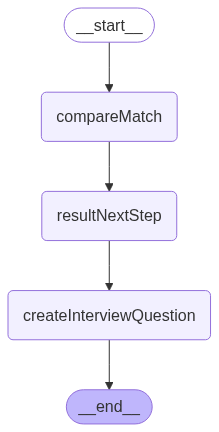

In [ ]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())